In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [55]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_id = test['Id']

### Explanatory Data Analysis

In [56]:
print('train shape = ', train.shape)
print('test shape = ', test.shape)
train.head()

train shape =  (1460, 81)
test shape =  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Remove the 'ID' column

In [57]:
train.drop(labels = 'Id', axis = 1, inplace = True)
test.drop(labels = 'Id', axis = 1, inplace = True)

#### Looking at the SalePrice

In [58]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

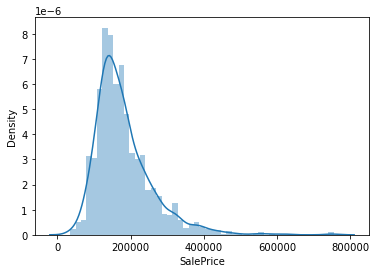

In [59]:
# check the distribution of SalePrice
sns.distplot(train.SalePrice)

In [60]:
# skewness greater than 0 is said to be positively skewed - right skewed
print(f'The skewness of SalePrice -> {train.SalePrice.skew()}')
# Positive kurtosis indicates a distribution with tails heavier (more outliers) than a normal distribution, and its peak is sharper.
print(f'The kurtosis of SalePrice -> {train.SalePrice.kurt()}')

The skewness of SalePrice -> 1.8828757597682129
The kurtosis of SalePrice -> 6.536281860064529


#### Concatenate the train and test together for extracting insights into the Housing Price data as a whole

In [61]:
train_test = pd.concat([train.drop(labels = 'SalePrice', axis = 1), test], axis = 0).reset_index(drop = True)

In [62]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [63]:
# 'MSSubClass' is nominal categorical variable
numerical = train_test.select_dtypes(exclude = ['object']).drop(labels = 'MSSubClass', axis = 1)
numerical.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

#### There are discrete and continuous variable

In [64]:
discrete_var = ['YearBuilt', 'YearRemodAdd', 'OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
           'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
continuous_var = []

for i in numerical.columns:
    if i not in discrete_var:
        continuous_var.append(i)
        
continuous_var

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

#### For categorical variable

In [65]:
categorical_var = train_test.select_dtypes('object')
categorical_var['MSSubClass'] = train_test['MSSubClass']
categorical_var.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

#### Visualization for continuous variables

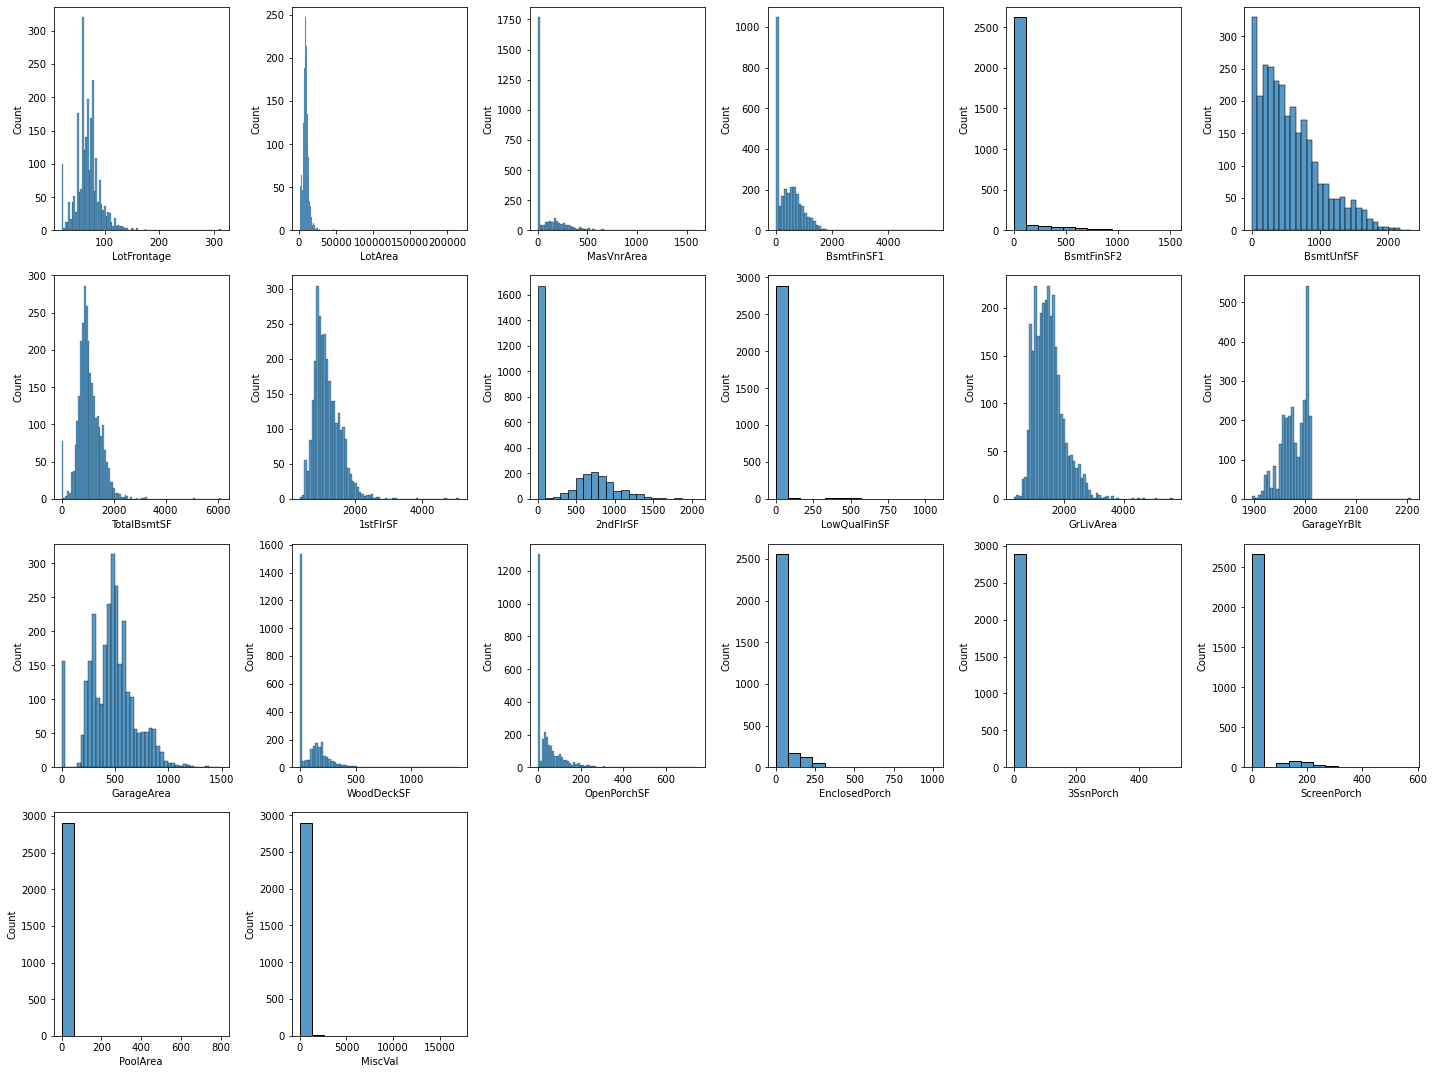

In [69]:
fig = plt.figure(figsize = (20,15))
for i, j in enumerate(continuous_var):
    plt.subplot(4,6,i + 1)
    sns.histplot(numerical.loc[:,j].dropna())
    
fig.tight_layout(pad = 1)

For variables:
> + MiscVal
> + PoolArea
> + ScreenPorch
> + 3SsnPorch
> + EnclosedPorch
> + LowQualFinSF
> + BsmtFinSF2

There are too many 0s in these features, these features may not provide any useful information, we can delete them later in the preprocessing step

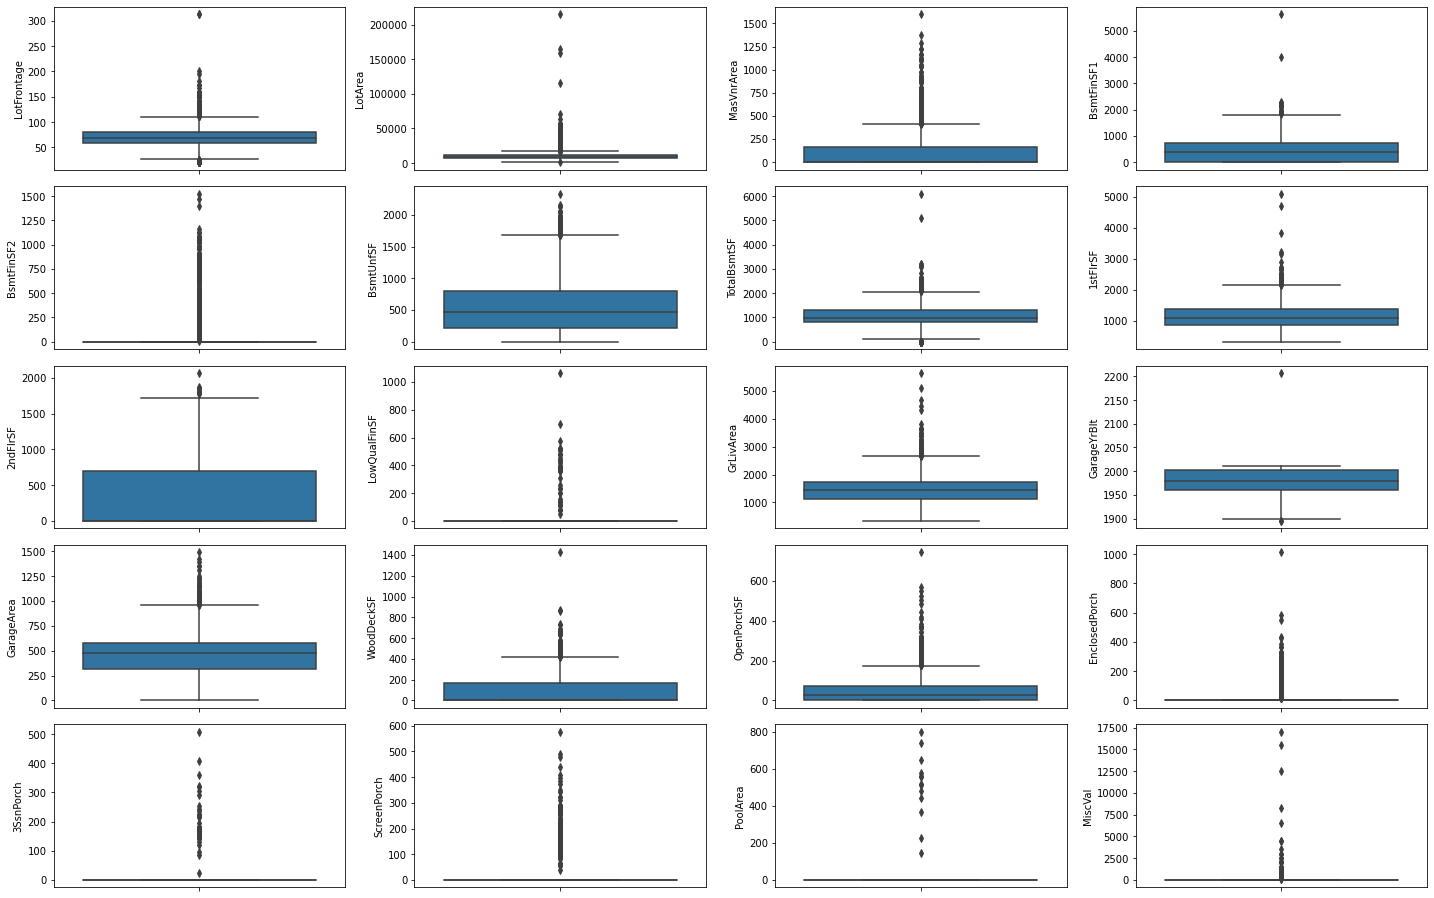

In [14]:
fig = plt.figure(figsize=(20,15))
for i,j in enumerate(continuous_var):
    plt.subplot(6,4,i+1)
    sns.boxplot(y = numerical.loc[:,j].dropna())
fig.tight_layout(pad=1.0)

#### Visualization for discrete variables

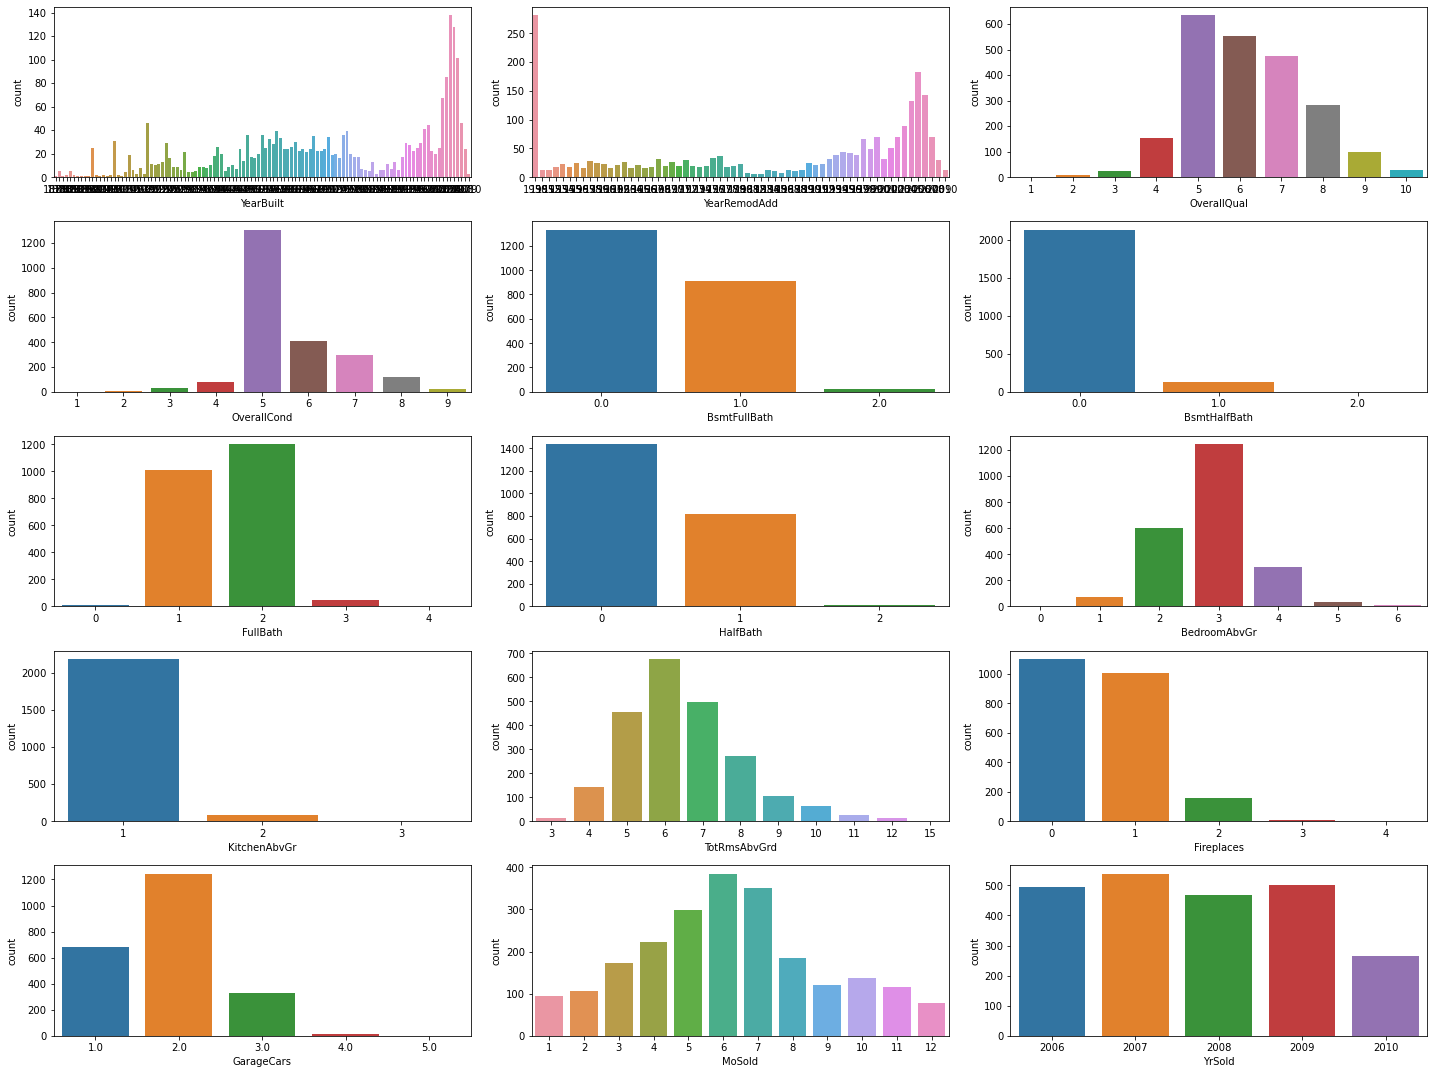

In [15]:
fig = plt.figure(figsize = (20,15))
for i,j in enumerate(discrete_var):
    plt.subplot(5,3,i+1)
    sns.countplot(x = j, data = numerical.dropna())
fig.tight_layout(pad=1.0)

For variables:
> + BsmtHalfBath
> + KitchenAbvGr

There are only one class dominating these features, they may not be able to provide any useful predicting power, maybe we can remove them later in the preprocessing step

#### Visualization for categorical variables

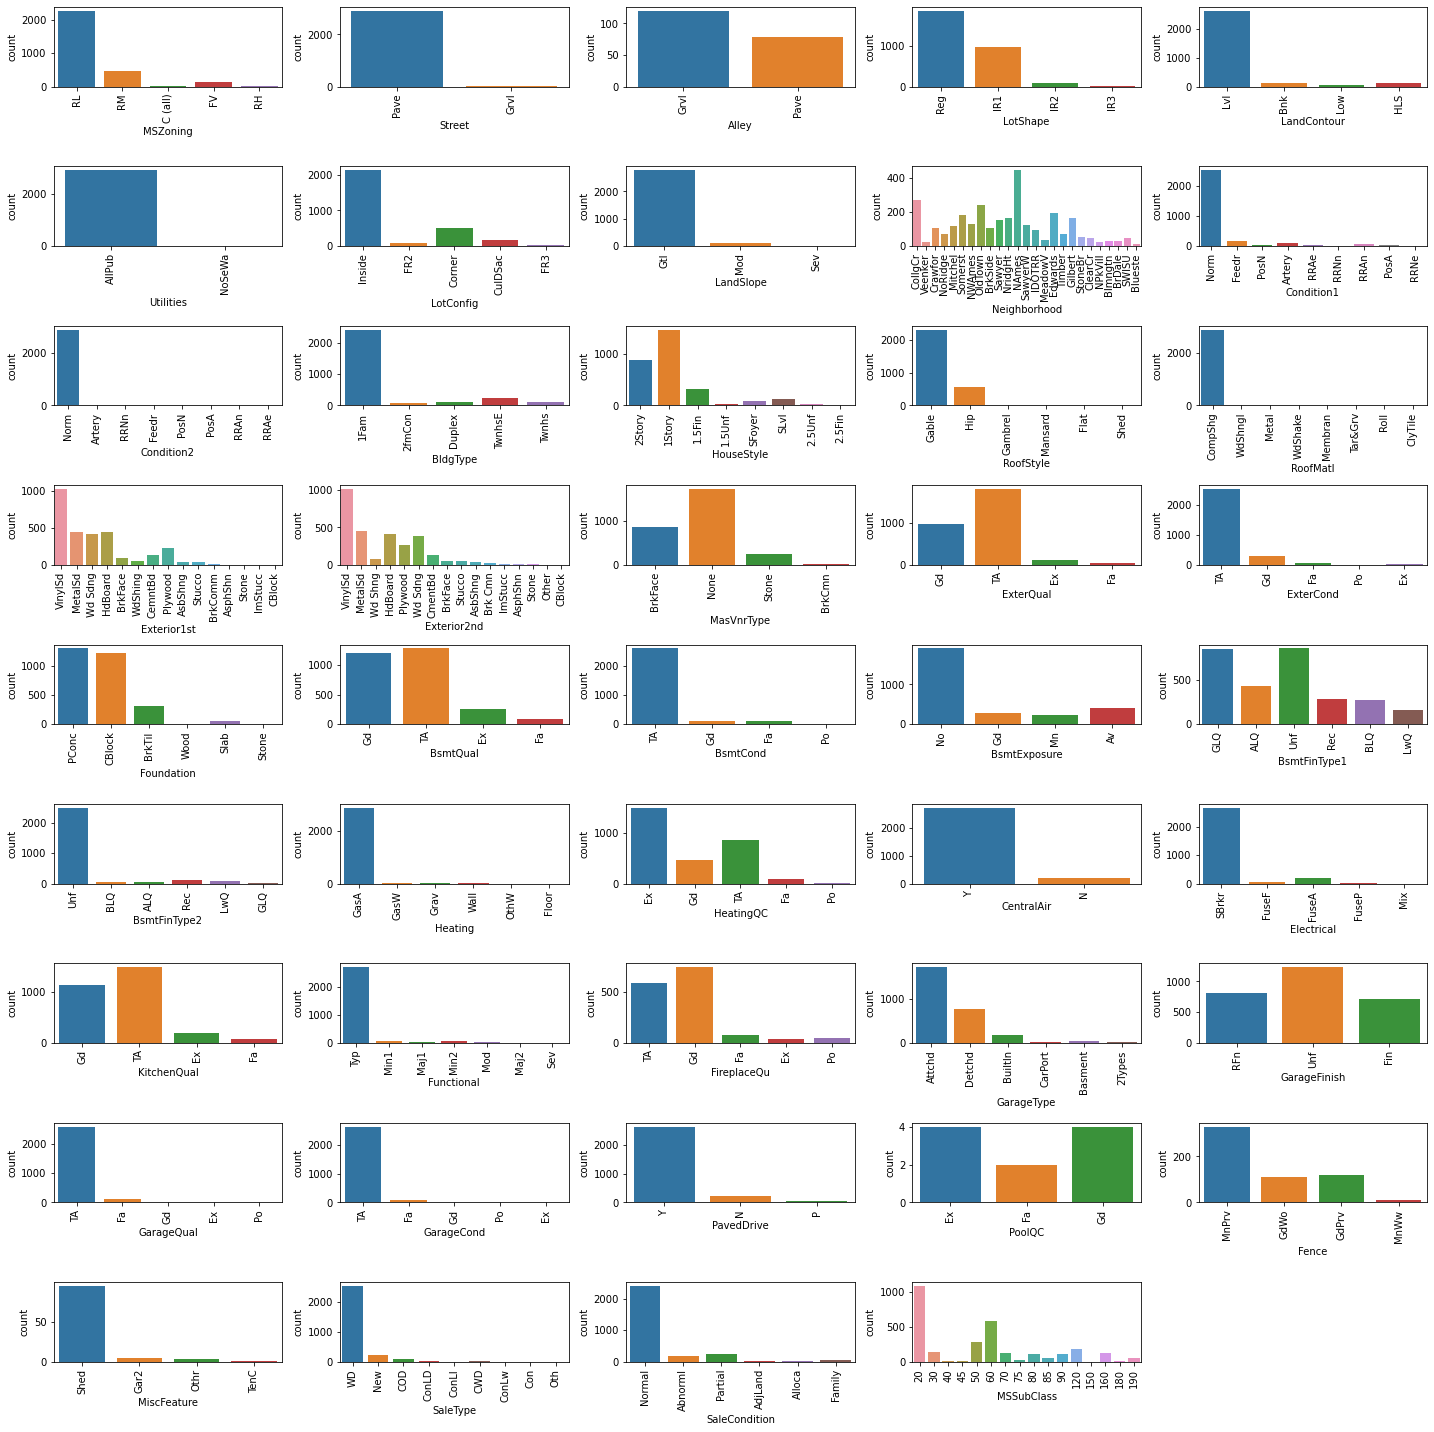

In [16]:
fig = plt.figure(figsize=(20,20))
for i, j in enumerate(categorical_var.columns):
    plt.subplot(9,5, i + 1)
    sns.countplot(x = categorical_var[j].dropna())
    plt.xticks(rotation = 90)
fig.tight_layout(pad = 1)

Similarly, there also exists some variables that only consist one major class, we can eliminate them later

<AxesSubplot:>

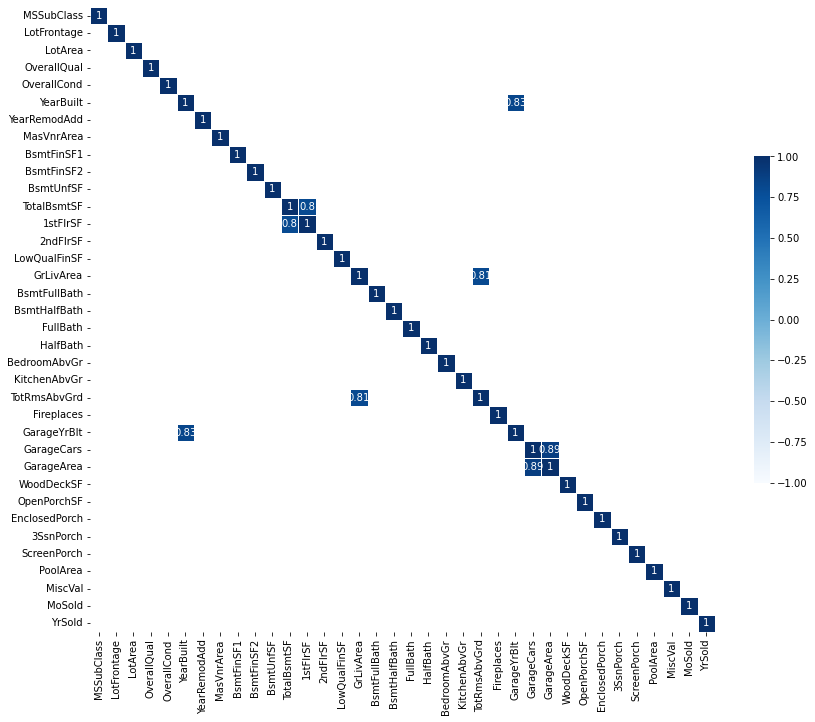

In [17]:
plt.figure(figsize=(14,12))
cor_matrix = train_test.corr()
sns.heatmap(cor_matrix, mask = cor_matrix < 0.7, 
            linewidth = 0.5, cmap='Blues', 
            annot = True, square = True, 
            center = 0, vmax = 1, 
            vmin= -1, cbar_kws = {'shrink':0.5})

Potential issue with multicolinearity:
> + GarageYrBlt and YearBuilt
> + TotRmsAbvGrd and GrLivArea
> + 1stFlrSF and TotalBsmtSF
> + GarageArea and GarageCars

#### Relationships between numerical features and target variables

<AxesSubplot:>

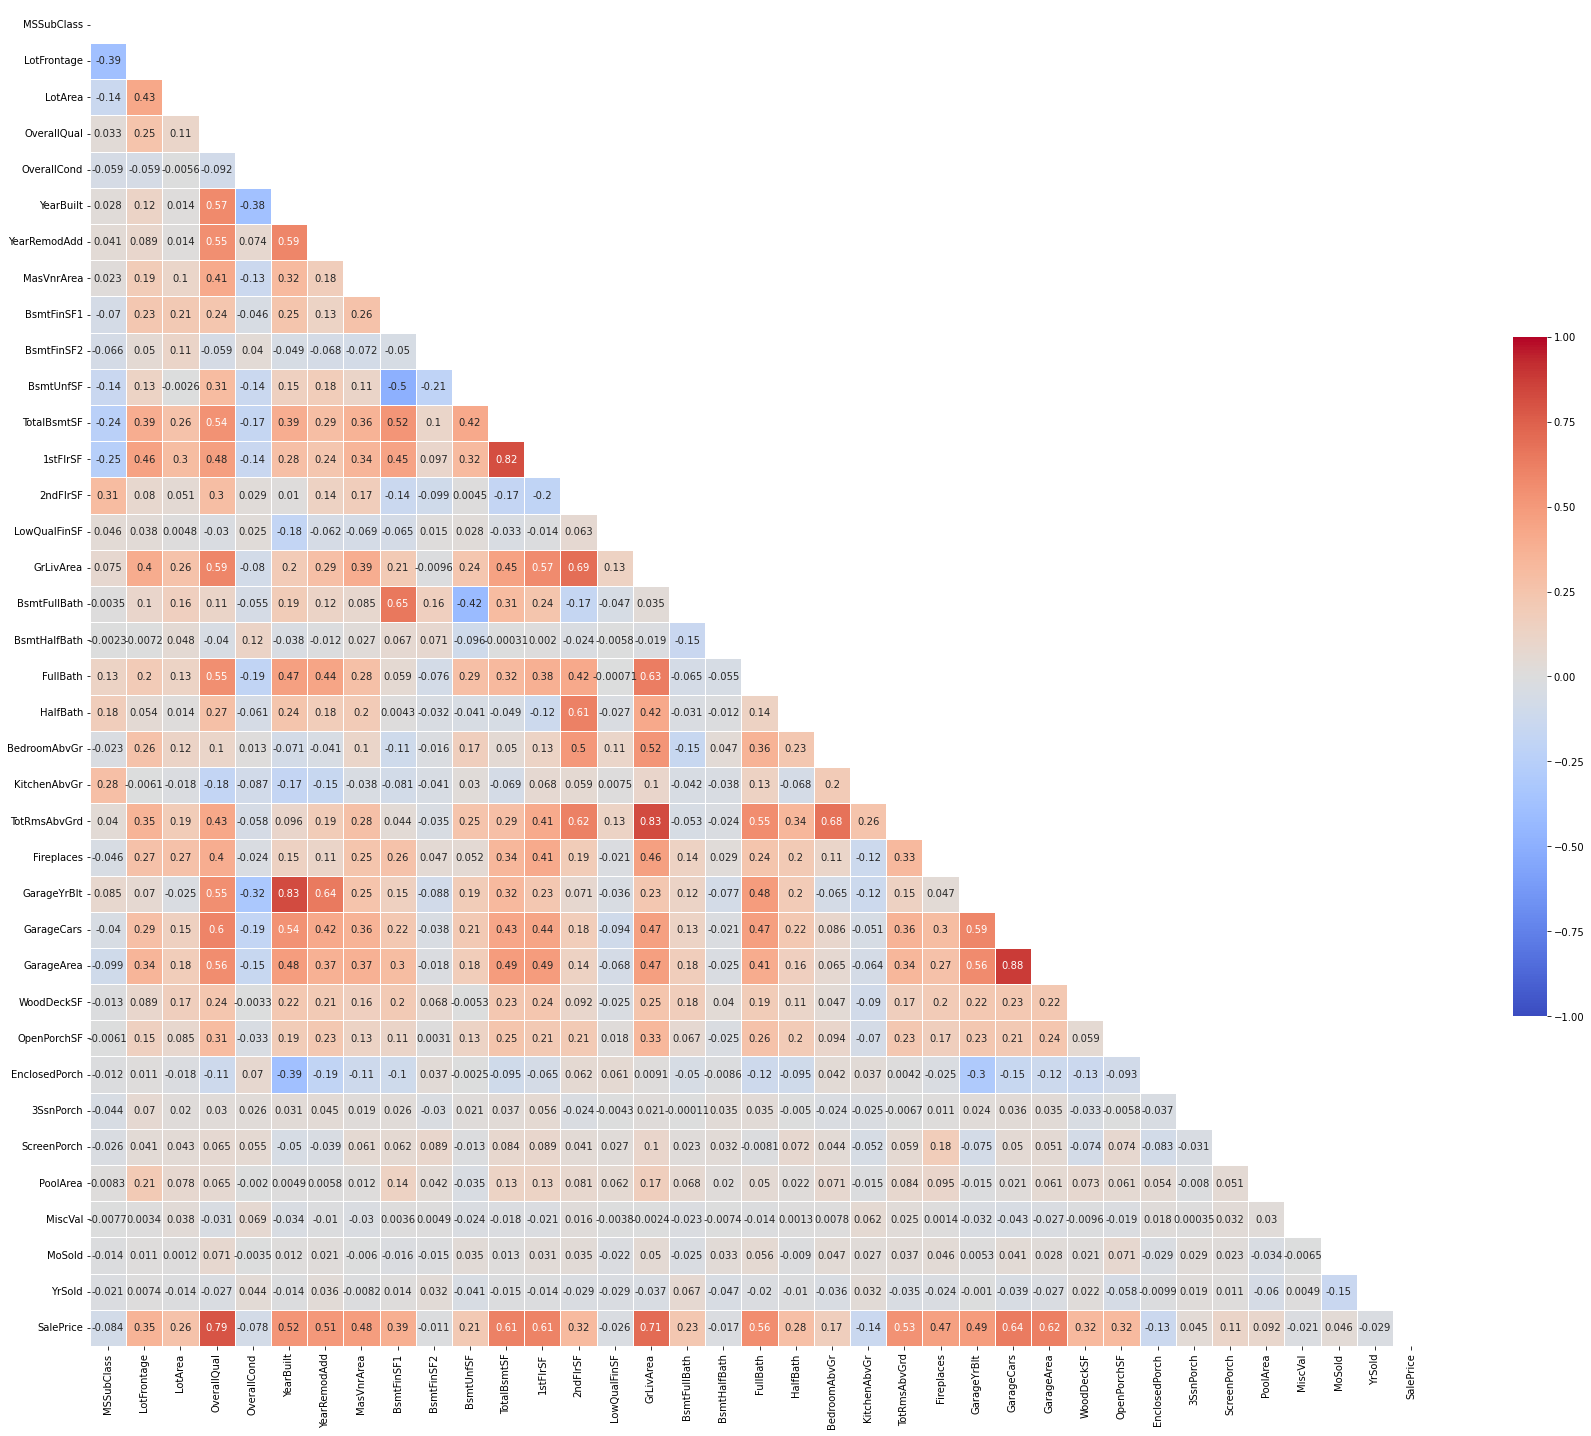

In [18]:
# Compute the correlation matrix
cor_matrix = train.corr('pearson')
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype = bool))

plt.figure(figsize=(30,25))
sns.heatmap(cor_matrix, mask = mask, 
            cmap = 'coolwarm', square = True, 
            annot = True, center = 0, 
            vmax = 1, vmin= -1, 
            cbar_kws = {'shrink':0.5}, linewidths = 0.5)

In [19]:
cor_matrix.loc['SalePrice'][abs(cor_matrix.loc['SalePrice']) > 0.5].sort_values(ascending = False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

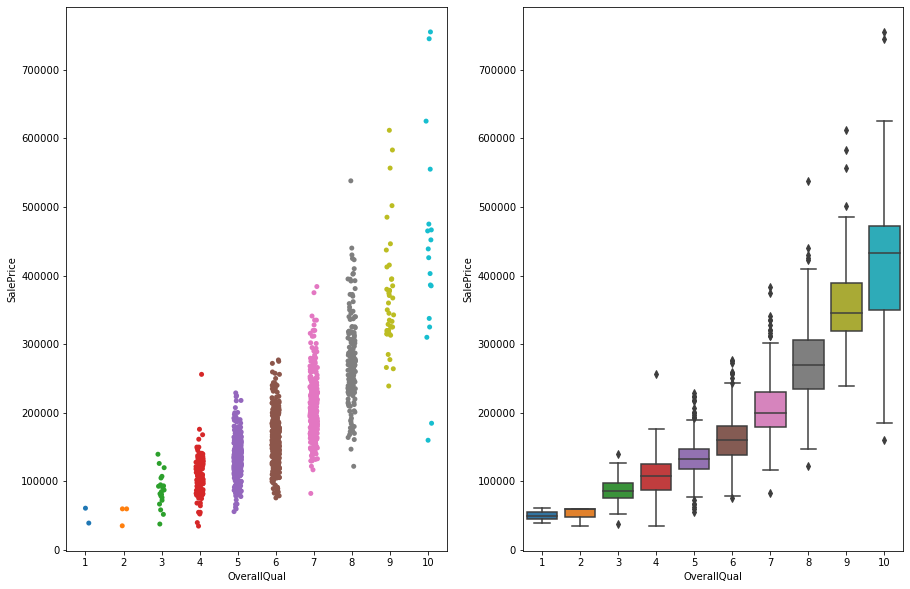

In [20]:
# OverallQual vs. SalePrice -> 0.790982
fig, ax = plt.subplots(1,2, figsize = (15,10))
sns.stripplot(x = 'OverallQual', y = 'SalePrice', data = train, ax = ax[0])
sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = train, ax = ax[1])

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

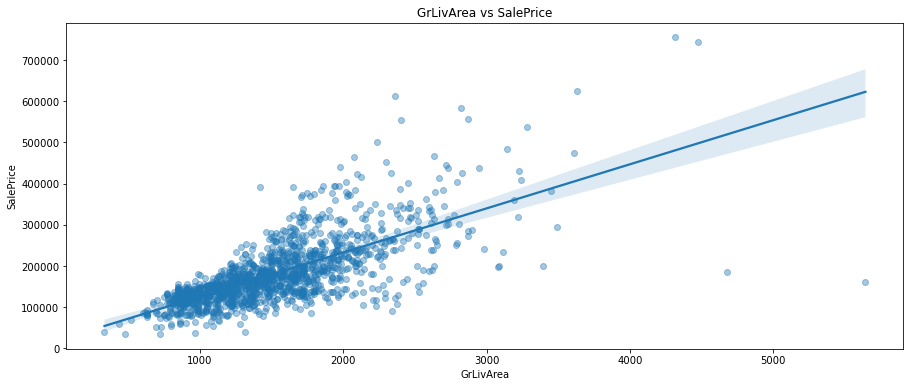

In [21]:
# GrLivArea vs SalePrice -> 0.708624
plt.figure(figsize=(15,6))
sns.regplot(x = 'GrLivArea', y = 'SalePrice', data = train, scatter_kws = {'alpha':0.4})
plt.title('GrLivArea vs SalePrice', fontsize = 12)

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

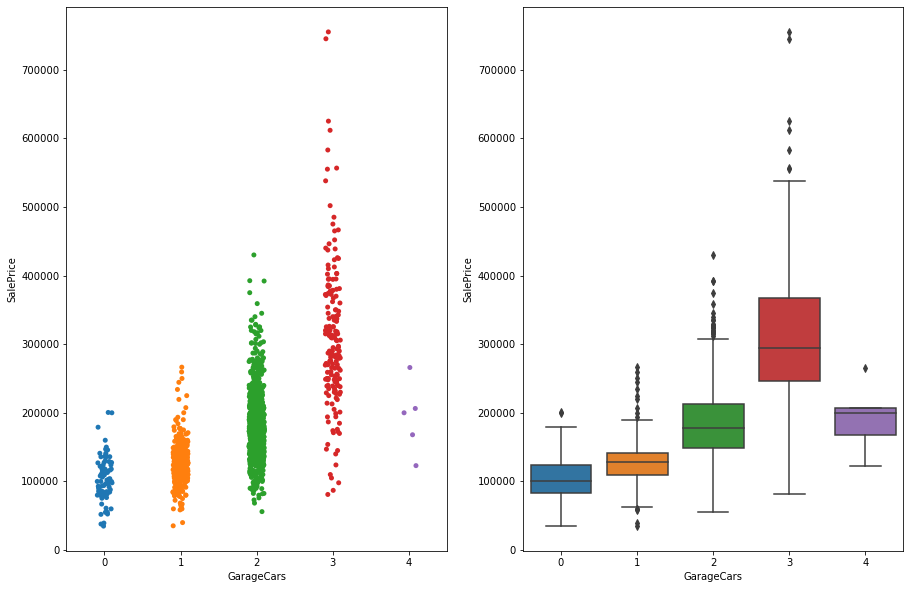

In [22]:
# GarageCars vs. SalePrice -> 0.640409
fig, ax = plt.subplots(1,2, figsize = (15,10))
sns.stripplot(x = 'GarageCars', y = 'SalePrice', data = train, ax = ax[0])
sns.boxplot(x = 'GarageCars', y = 'SalePrice', data = train, ax = ax[1])

Text(0.5, 1.0, 'GarageArea vs SalePrice')

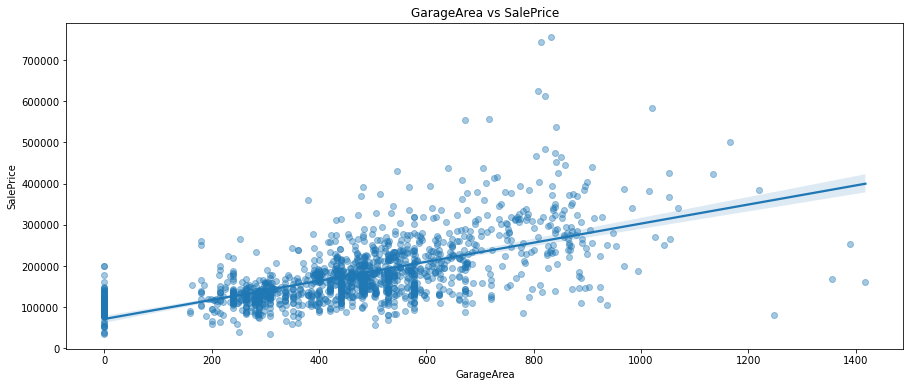

In [23]:
# GarageArea vs. SalePrice -> GarageArea
plt.figure(figsize=(15,6))
sns.regplot(x = 'GarageArea', y = 'SalePrice', data = train, scatter_kws = {'alpha':0.4})
plt.title('GarageArea vs SalePrice', fontsize = 12)

# some house do not have garage

Text(0.5, 1.0, 'TotalBsmtSF vs SalePrice')

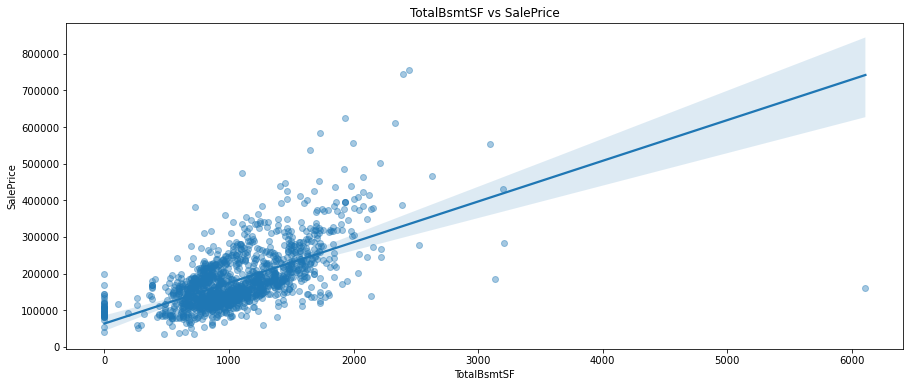

In [24]:
# TotalBsmtSF vs. SalePrice -> 0.613581
plt.figure(figsize=(15,6))
sns.regplot(x = 'TotalBsmtSF', y = 'SalePrice', data = train, scatter_kws = {'alpha':0.4})
plt.title('TotalBsmtSF vs SalePrice', fontsize = 12)

# some house do not have basement

Text(0.5, 1.0, '1stFlrSF vs SalePrice')

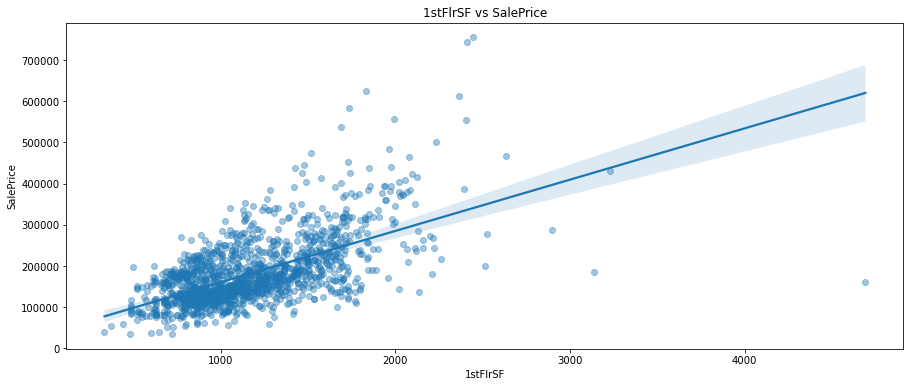

In [25]:
# 1stFlrSF vs SalePrice -> 0.605852
plt.figure(figsize=(15,6))
sns.regplot(x = '1stFlrSF', y = 'SalePrice', data = train, scatter_kws = {'alpha':0.4})
plt.title('1stFlrSF vs SalePrice', fontsize = 12)

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

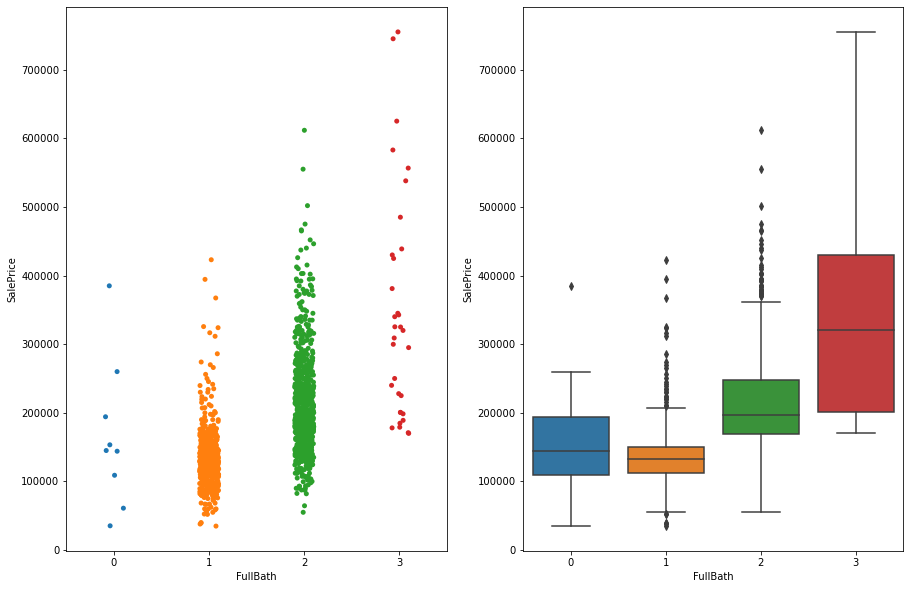

In [26]:
# FullBath vs SalePrice
fig, ax = plt.subplots(1,2, figsize = (15,10))
sns.stripplot(x = 'FullBath', y = 'SalePrice', data = train, ax = ax[0])
sns.boxplot(x = 'FullBath', y = 'SalePrice', data = train, ax = ax[1])

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

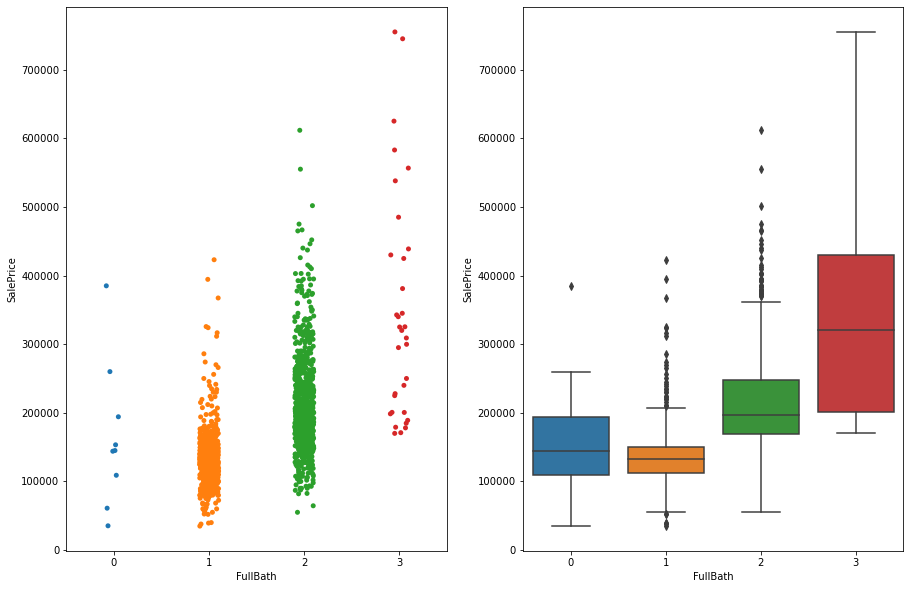

In [27]:
# TotRmsAbvGrd vs SalePrice
fig, ax = plt.subplots(1,2, figsize = (15,10))
sns.stripplot(x = 'FullBath', y = 'SalePrice', data = train, ax = ax[0])
sns.boxplot(x = 'FullBath', y = 'SalePrice', data = train, ax = ax[1])

Text(0.5, 1.0, 'YearBuilt vs SalePrice')

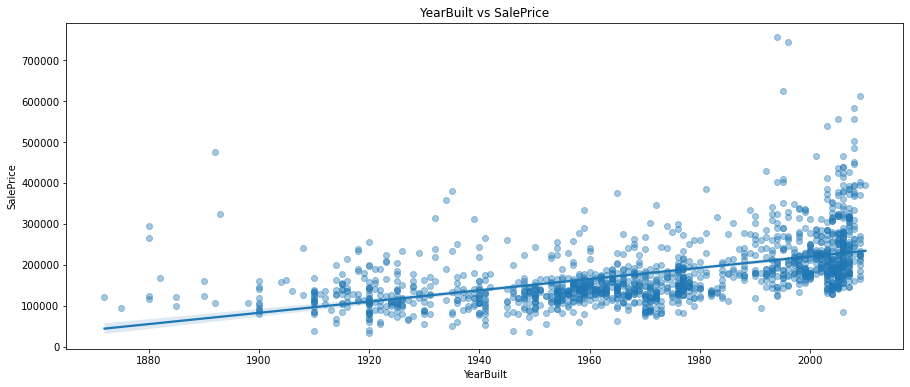

In [28]:
# YearBuilt vs SalePrice
plt.figure(figsize=(15,6))
sns.regplot(x = 'YearBuilt', y = 'SalePrice', data = train, scatter_kws = {'alpha':0.4})
plt.title('YearBuilt vs SalePrice', fontsize = 12)

Text(0.5, 1.0, 'YearRemodAdd vs SalePrice')

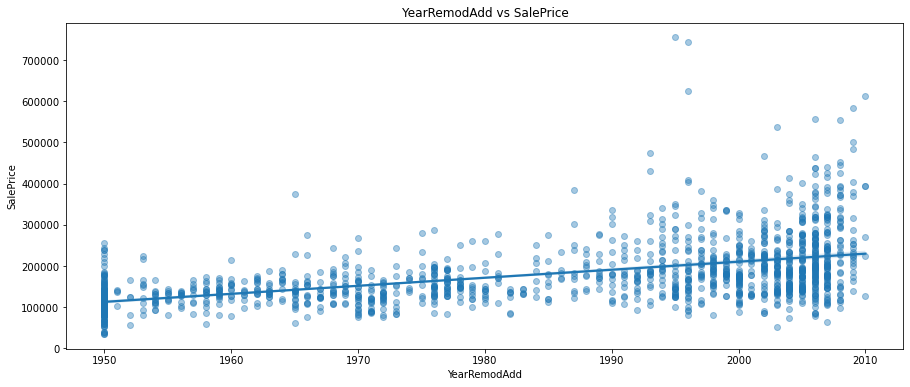

In [29]:
# YearRemodAdd vs SalePrice
plt.figure(figsize=(15,6))
sns.regplot(x = 'YearRemodAdd', y = 'SalePrice', data = train, scatter_kws = {'alpha':0.4})
plt.title('YearRemodAdd vs SalePrice', fontsize = 12)

### Data Preprocessing

#### Multicolinearity
We remove the ones with lower correlation coefficient

In [30]:
train_test.drop(labels = ['GarageYrBlt', 'TotRmsAbvGrd', 
                          '1stFlrSF', 'GarageCars'], axis = 1, inplace = True)

#### Features with too many missing values

In [31]:
missing_table = (train.isnull().sum(axis = 0) / train.shape[0]).sort_values(ascending = False)
missing_table = missing_table[missing_table != 0]
num_missing = train.isnull().sum(axis = 0).sort_values(ascending = False)
num_missing = num_missing[num_missing != 0]

missing = pd.DataFrame()
missing['features'] = missing_table.index
missing['num_missing'] = num_missing.values
missing['perct_missing'] = missing_table.values

missing

,features,num_missing,perct_missing
0,PoolQC,1453,0.995205
1,MiscFeature,1406,0.963014
2,Alley,1369,0.937671
3,Fence,1179,0.807534
4,FireplaceQu,690,0.472603
5,LotFrontage,259,0.177397
6,GarageYrBlt,81,0.055479
7,GarageCond,81,0.055479
8,GarageType,81,0.055479
9,GarageFinish,81,0.055479


In [32]:
train_test.drop(labels = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1, inplace = True)

#### Features mostly dominated by 1 class

For features with more than 95% of data points are same value, we can remove them

In [33]:
def col_with_dominant(data, threshold = 0.95):
    '''
    This function will return the columns that have 95% of data points being dominated by one value
    '''
    col_to_drop = []
    for col in data.columns:
        sorted_value_count = data[col].value_counts(normalize = True).sort_values(ascending = False)
        if sorted_value_count.values[0] > threshold:
            col_to_drop.append(col)
    return col_to_drop

In [34]:
col_with_dominant(train_test)

['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'Heating',
 'LowQualFinSF',
 'KitchenAbvGr',
 'GarageCond',
 '3SsnPorch',
 'PoolArea',
 'MiscVal']

In [35]:
train_test.drop(labels = col_with_dominant(train_test), axis = 1, inplace = True)

#### Look for features that have low linear relationship with SalePrice
We set a threshold of 0.05 

In [36]:
no_lin_rel = cor_matrix.loc['SalePrice'][abs(cor_matrix.loc['SalePrice']) < 0.05].sort_values(ascending = False)
no_lin_rel

MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
MiscVal        -0.021190
LowQualFinSF   -0.025606
YrSold         -0.028923
Name: SalePrice, dtype: float64

In [37]:
for col in no_lin_rel.index:
    if col in train_test.columns:
        train_test.drop(labels = col, axis = 1, inplace = True)

#### Let's split data back to train and test set

In [38]:
sale_price = train['SalePrice']
train = train_test.iloc[0:1460, :]
train['SalePrice'] = sale_price
test = train_test.iloc[1460:, :]

#### Outliers - IQR method with median imputation - only for continuous variable

In [39]:
def outlier_median_impute(data):
    '''
    this function takes one feature each time
    and only works for numerical features
    '''
    
    median = data.median()
    
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # imputation
    data[(data > upper_bound) | (data < lower_bound)] = median
    
    return data

In [40]:
def outlier_imputation(data):
    continuous_data = data
    for col in continuous_data.columns:
        continuous_data[col] = outlier_median_impute(continuous_data[col])
    return continuous_data

In [41]:
new_continuous_var = []
for col in continuous_var:
    if col in train.columns:
        new_continuous_var.append(col)

In [42]:
new_continuous_var

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch']

In [43]:
train[new_continuous_var] = outlier_imputation(train[new_continuous_var])

#### Missing Values

In [44]:
missing_table = (train.isnull().sum(axis = 0) / train.shape[0]).sort_values(ascending = False)
missing_table = missing_table[missing_table != 0]
num_missing = train.isnull().sum(axis = 0).sort_values(ascending = False)
num_missing = num_missing[num_missing != 0]

missing = pd.DataFrame()
missing['features'] = missing_table.index
missing['num_missing'] = num_missing.values
missing['perct_missing'] = missing_table.values

missing

,features,num_missing,perct_missing
0,FireplaceQu,690,0.472603
1,LotFrontage,259,0.177397
2,GarageFinish,81,0.055479
3,GarageQual,81,0.055479
4,GarageType,81,0.055479
5,BsmtFinType2,38,0.026027
6,BsmtExposure,38,0.026027
7,BsmtFinType1,37,0.025342
8,BsmtCond,37,0.025342
9,BsmtQual,37,0.025342


#### Categorical Variables

#### For these features, NA means there is no such thing, we can impute "None" to them

In [45]:
SalePrice = train['SalePrice']
train.drop(labels = 'SalePrice', axis = 1, inplace = True)

In [46]:
col = ['FireplaceQu','GarageFinish', 'GarageQual', 'GarageType',
            'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 
            'MasVnrType']
imputer = SimpleImputer(strategy = 'constant', fill_value = 'None')
train_temp = imputer.fit_transform(train[col])
test_temp = imputer.transform(test[col])

# convert them back to pandas DataFrame
train[col] = pd.DataFrame(train_temp, columns = col, index = train.index)
test[col] = pd.DataFrame(test_temp, columns = col, index = test.index)

#### For all the other features, we just use the most frequent term to impute them
#### Note that "MSSubClass" is a nominal categorical variable

In [47]:
col = ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 
                'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
                'RoofStyle','Exterior1st', 'Exterior2nd', 'ExterQual', 
                'ExterCond', 'Foundation', 'HeatingQC','CentralAir', 
                'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 
                'SaleType', 'SaleCondition']
imputer = SimpleImputer(strategy = 'most_frequent')
train_temp = imputer.fit_transform(train[col])
test_temp = imputer.transform(test[col])

# convert them back to pandas DataFrame
train[col] = pd.DataFrame(train_temp, columns = col, index = train.index)
test[col] = pd.DataFrame(test_temp, columns = col, index = test.index)

In [48]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageFinish,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition
0,60,RL,65.0,8450.0,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,RFn,548.0,TA,Y,0,61,0,0,WD,Normal
1,20,RL,80.0,9600.0,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,RFn,460.0,TA,Y,298,0,0,0,WD,Normal
2,60,RL,68.0,11250.0,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,RFn,608.0,TA,Y,0,42,0,0,WD,Normal
3,70,RL,60.0,9550.0,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,Unf,642.0,TA,Y,0,35,0,0,WD,Abnorml
4,60,RL,84.0,14260.0,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,RFn,836.0,TA,Y,192,84,0,0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917.0,Reg,Lvl,Inside,Gilbert,Norm,1Fam,...,RFn,460.0,TA,Y,0,40,0,0,WD,Normal
1456,20,RL,85.0,13175.0,Reg,Lvl,Inside,NWAmes,Norm,1Fam,...,Unf,500.0,TA,Y,349,0,0,0,WD,Normal
1457,70,RL,66.0,9042.0,Reg,Lvl,Inside,Crawfor,Norm,1Fam,...,RFn,252.0,TA,Y,0,60,0,0,WD,Normal
1458,20,RL,68.0,9717.0,Reg,Lvl,Inside,NAmes,Norm,1Fam,...,Unf,240.0,TA,Y,366,0,0,0,WD,Normal


#### Numerical Variables

#### For these features, we impute mean to them, since we have already done the outlier removal

In [49]:
col = ['LotFrontage', 'LotArea', 'GrLivArea', 'WoodDeckSF', 
                   'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']
imputer = SimpleImputer(strategy = 'mean')
train_temp = imputer.fit_transform(train[col])
test_temp = imputer.transform(test[col])

# convert them back to pandas DataFrame
train[col] = pd.DataFrame(train_temp, columns = col, index = train.index)
test[col] = pd.DataFrame(test_temp, columns = col, index = test.index)

#### For these features, we impute 0 to them

In [50]:
col = ['MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
                   '2ndFlrSF', 'BsmtFullBath','FullBath','HalfBath',
                   'Fireplaces','GarageArea', 'BedroomAbvGr']
imputer = SimpleImputer(strategy = 'constant', fill_value = 0)
train_temp = imputer.fit_transform(train[col])
test_temp = imputer.transform(test[col])

# convert them back to pandas DataFrame
train[col] = pd.DataFrame(train_temp, columns = col, index = train.index)
test[col] = pd.DataFrame(test_temp, columns = col, index = test.index)

In [51]:
# adding target variable back to trian
train['SalePrice'] = SalePrice

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrTy

#### Feature engineering

> + TotalLot = LotFrontage + LotArea
> + TotalBath = FullBath + 1/2 * HalfBath

In [53]:
# TotalLot
train['TotalLot'] = train['LotFrontage'] + train['LotArea']
test['TotalLot'] = test['LotFrontage'] + test['LotArea']

# TotalBath
train['TotalBath'] = train['FullBath'] + (0.5 * train['HalfBath'])
test['TotalBath'] = test['FullBath'] + (0.5 * test['HalfBath'])

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition,SalePrice,TotalLot,TotalBath
0,60,RL,65.0,8450.0,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0.0,61.0,0.0,0.0,WD,Normal,208500,8515.0,2.5
1,20,RL,80.0,9600.0,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,Y,298.0,0.0,0.0,0.0,WD,Normal,181500,9680.0,2.0
2,60,RL,68.0,11250.0,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,Y,0.0,42.0,0.0,0.0,WD,Normal,223500,11318.0,2.5
3,70,RL,60.0,9550.0,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,Y,0.0,35.0,0.0,0.0,WD,Abnorml,140000,9610.0,1.0
4,60,RL,84.0,14260.0,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,Y,192.0,84.0,0.0,0.0,WD,Normal,250000,14344.0,2.5


#### Ordinal Encoding

Since some class in the test is not presented in the training data, the best way is to combine both of them to do encoding

In [54]:
train_test = pd.concat([train.drop(labels = 'SalePrice', axis = 1), test], axis = 0)

In [55]:
train_test.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [56]:
ordinal_var = ['LotShape', 'ExterQual', 'ExterCond', 'BsmtQual', 
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 
               'GarageFinish', 'GarageQual']

In [57]:
map_table  = {
                'Reg':3,'IR1':2,'IR2':1,'IR3':0,
                'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0,
                'Av': 3,'Mn': 2, 'No':1,
                'Unf' : 1,'LwQ': 2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6,
                'Y':1,'N':0,
                'Fin':3,'RFn':2,'Unf':1, 
}

for col in ordinal_var:
    train_test[col] = train_test[col].map(map_table)

#### One-Hot Encoding

In [58]:
rest = train_test.select_dtypes(include = ['object']).columns
rest

Index(['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Electrical', 'Functional', 'GarageType',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [59]:
train_test = pd.get_dummies(train_test, columns = rest, drop_first = True)
train_test

,MSSubClass,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450.0,3,7,5,2003,2003,196.0,4,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600.0,3,6,8,1976,1976,0.0,3,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250.0,2,7,5,2001,2002,162.0,4,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550.0,2,7,5,1915,1970,0.0,3,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260.0,2,8,5,2000,2000,350.0,4,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936.0,3,4,7,1970,1970,0.0,3,...,0,0,0,0,1,0,0,0,1,0
2915,160,21.0,1894.0,3,4,5,1970,1970,0.0,3,...,0,0,0,0,1,0,0,0,0,0
2916,20,160.0,20000.0,3,5,7,1960,1996,0.0,3,...,0,0,0,0,1,0,0,0,0,0
2917,85,62.0,10441.0,3,5,5,1992,1992,0.0,3,...,0,0,0,0,1,0,0,0,1,0


In [60]:
# lets split the training and testing data again
train = train_test.iloc[0:1460, :]
y = SalePrice
test = train_test.iloc[1460:, :]

#### Log the target variable

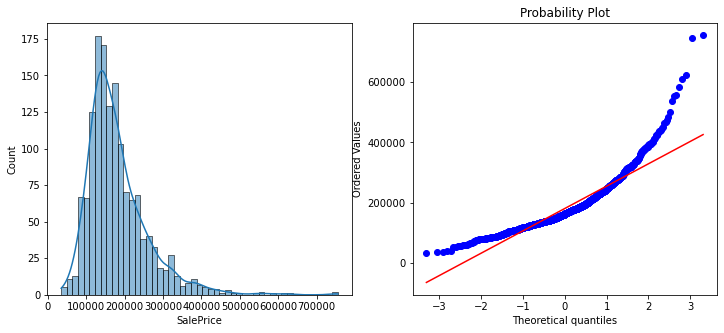

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
sns.histplot(y, kde = True, ax = ax[0])
stats.probplot(y, dist = 'norm', plot = ax[1])
plt.show()

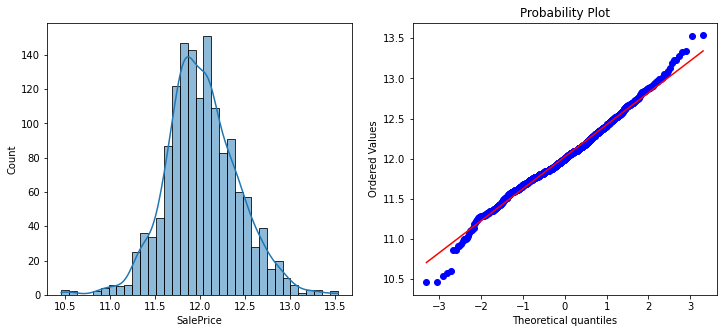

In [62]:
y = np.log(y)

fig, ax = plt.subplots(1, 2, figsize = (12,5))
sns.histplot(y, kde = True, ax = ax[0])
stats.probplot(y, dist = 'norm', plot = ax[1])
plt.show()

#### Normalization - Better!!!!

In [63]:
scalar = MinMaxScaler()
train_new = scalar.fit_transform(train)
test_new = scalar.transform(test)

#### Standardization

In [64]:
# scalar = StandardScaler()
# train_new = scalar.fit_transform(train)
# test_new = scalar.transform(test)

#### RobustScaler

In [65]:
# rb_scaler = RobustScaler()
# train_new = rb_scaler.fit_transform(train)
# test_new = rb_scaler.transform(test)

## Modeling

#### Lasso Regression with Hyperparameter tuning

In [66]:
param_grid = {'alpha': np.logspace(-4, 4, 20)}

lasso = Lasso(tol = 0.01)
lasso_reg = GridSearchCV(lasso, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

lasso_reg.fit(train_new, y)

print(f"Best parameters: {lasso_reg.best_params_}")
print(f"Best score: {-lasso_reg.best_score_}")

Best parameters: {'alpha': 0.00026366508987303583}
Best score: 0.01726877361454423


In [67]:
# identifying most important features
lasso = lasso_reg.best_estimator_
lasso.fit(train_new, y)

lasso_pred = lasso.predict(test_new)
lasso_pred = np.exp(lasso_pred)
lasso_pred

array([121248.01791577, 170996.55534797, 182729.57885872, ...,
       182883.67255767, 114612.76909794, 221927.84197938])

#### Ridge Regression with Hyperparameter tuning

In [68]:
param_grid = {'alpha' : np.logspace(-4, -4, 20)}

ridge = Ridge(tol = 0.01)
ridge_reg = GridSearchCV(ridge, param_grid, cv = 5, scoring = 'neg_mean_squared_error')

ridge_reg.fit(train_new, y)

print(f"Best parameters: {ridge_reg.best_params_}")
print(f"Best score: {-ridge_reg.best_score_}")

Best parameters: {'alpha': 0.0001}
Best score: 0.019053823173950872


In [69]:
ridge = ridge_reg.best_estimator_
ridge.fit(train_new, y)

ridge_pred = ridge.predict(test_new)
ridge_pred = np.exp(ridge_pred)
ridge_pred

array([123948.73034999, 172011.79038846, 184510.03181024, ...,
       185994.99587861, 110699.61912673, 217638.15975611])

#### Extreme Gradient Boosting

In [71]:
xgb = XGBRegressor()

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(xgb, param_lst, scoring = 'neg_mean_squared_error', cv = 5)
xgb_reg.fit(train_new, y)

print(f"Best parameters: {xgb_reg.best_params_}")
print(f"Best score: {-xgb_reg.best_score_}")

Best parameters: {'reg_lambda': 0.01, 'reg_alpha': 0.001, 'n_estimators': 3000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01}
Best score: 0.0168359630936869


In [72]:
xgboost = xgb_reg.best_estimator_
xgboost.fit(train_new, y)

xgb_pred = xgboost.predict(test_new)
xgb_pred = np.exp(xgb_pred)
xgb_pred

array([121510.28 , 153566.47 , 192160.48 , ..., 160382.4  , 111835.195,
       217501.05 ], dtype=float32)

#### LightGBM

In [73]:
lgbm = LGBMRegressor()

param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lightgbm = RandomizedSearchCV(lgbm, param_lst, cv = 5, scoring = 'neg_mean_squared_error')
lightgbm.fit(train_new, y)

print(f"Best parameters: {lightgbm.best_params_}")
print(f"Best score: {-lightgbm.best_score_}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.0001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Cur

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

Best parameters: {'n_estimators': 1500, 'min_child_samples': 25, 'max_depth': 10, 'learning_rate': 0.01, 'lambda_l2': 0.01, 'lambda_l1': 0.01, 'feature_fraction': 0.8}
Best score: 0.017730798826969832


In [74]:
LightGBM = lightgbm.best_estimator_
LightGBM.fit(train_new, y)

lgbm_pred = LightGBM.predict(test_new)
lgbm_pred = np.exp(lgbm_pred)
lgbm_pred

array([120465.23220337, 159048.74114772, 188324.53051917, ...,
       159665.23813256, 110136.99898313, 225440.80021   ])

#### Catboost

In [75]:
cb = CatBoostRegressor(silent=True)

param_lst = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

catboost = RandomizedSearchCV(cb, param_lst, cv = 5, scoring = 'neg_mean_squared_error')
catboost.fit(train_new, y)

print(f"Best parameters: {catboost.best_params_}")
print(f"Best score: {-catboost.best_score_}")

Best parameters: {'rsm': 0.9, 'random_strength': 0.25, 'n_estimators': 500, 'min_child_samples': 5, 'max_depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 0.01}
Best score: 0.016073324341408346


In [76]:
CatBoost = catboost.best_estimator_
CatBoost.fit(train_new, y)

cb_pred = CatBoost.predict(test_new)
cb_pred = np.exp(cb_pred)
cb_pred

array([126865.12712759, 163291.5308913 , 184197.87995069, ...,
       162102.23405317, 112043.39382967, 223433.10918262])

#### Performance Comparison

In [77]:
performance_comp = pd.DataFrame({
    'Model_Name':['Lasso','Ridge', 'XGBoost','LightGBM','CatBoost'],
    'Model_MSE':[-lasso_reg.best_score_, -ridge_reg.best_score_, -xgb_reg.best_score_, -lightgbm.best_score_, -catboost.best_score_],
    'Model_RMSE':[np.sqrt(-lasso_reg.best_score_), np.sqrt(-ridge_reg.best_score_), np.sqrt(-xgb_reg.best_score_), np.sqrt(-lightgbm.best_score_), np.sqrt(-catboost.best_score_)]
})
performance_comp

,Model_Name,Model_MSE,Model_RMSE
0,Lasso,0.017269,0.131411
1,Ridge,0.019054,0.138036
2,XGBoost,0.016836,0.129753
3,LightGBM,0.017731,0.133157
4,CatBoost,0.016073,0.126781


#### Model Blending

In [87]:
def blending(w1, w2, w3, w4, test = test_new):
    prediction = (w1 * lasso_pred) + (w2 * xgb_pred) + (w3 * lgbm_pred) + (w4 * cb_pred)
    return prediction

In [91]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = blending(0, 0.4, 0.3, 0.3)
submission.to_csv('submission.csv', index = False)